# Financial Model

In [2]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta as ta
from pandas.plotting import scatter_matrix
import requests
from bs4 import BeautifulSoup
import unidecode
%matplotlib inline

In [3]:
#General_proccessing
# Gives the DATA and takes name of stock as a positional argument
def get_data(key,name):
    quandl.ApiConfig.api_key = 'c3r3kxJxarE5UxYMcmkA'
    data  = quandl.get(key, authtoken="c3r3kxJxarE5UxYMcmkA")
    data.columns.name = name
    return data
# Used to proccess the data , i.e it adds 2 columns id and date
def process(df):
    size = df.shape[0]
    lists = []
    for i in range(size):
        lists.append(i)
    lists2 = []
    for row in df.index:
        lists2.append(str(row.date()))
    df["Id"] = lists
    df["Date"] = lists2
    df['returns'] = (df['Close'] / df['Close'].shift(1) ) - 1
    print(df.head())
    print(df["Date"][-1])
    print(df["Date"][-31])
    print(df["Date"][-61])
    print(df["Date"][-91])
    print(df["Date"][-181])
    print(df["Date"][-361])
    return df
# Used to give general information about the data frame , takes dataframe as the positional argument
def information(df):
    print("Checking wether the dataframe is empty or not ")
    print(df.empty)
    print("Checking no of null values ")
    print(df.count())
    print(df.shape)
    print(df.info())
    print("Caluculating the mean")
    print(df.mean())
    print("Rounded of mean values ")
    print(df.mean().round())
    print("Rounded of mode values ")
    print(df.mode(axis='columns').round())
    print("Printing few first and last rows")
    print(df.head())
    print(df.tail())
def splitter_by_month(df,initial_date,no_of_days,column,no_of_months = 0):
        column_name = df.columns
        index = df['Id'][initial_date]
        if(no_of_months!=0):
            no_of_days = no_of_months*30
        return df[column_name[int(column)-1]][int(index):int(index)+no_of_days]

In [4]:
 #Basic_Indicators
def slope_calc(df,column,initial_date,months):
    column_name = df.columns
    index = df["Id"][initial_date]
    z = []
    date = []
    for i in range(months*30):
        z.append(df[column_name[column-1]][index+1] - df[column_name[column-1]][index])
        date.append(df["Date"][index])
        index = index +1
    print(sum(z)/len(z))
    display2(z,date,"Slope per between days")
    return z
# Calculates volatility of days
def voly_calc(df,initial_date,months):
    index = df["Id"][initial_date]
    vol = []
    date = []
    for i in range(months*30):
        vol.append(df["High"][index]-df["Close"][index])
        date.append(df["Date"][index])
        index = index + 1
    print(sum(vol)/len(vol))
    display2(vol,date,"Volatility in Days")
    return vol
# Returns simple moving average on the basis of initial_date column_no and days and period
def sma(df,initial_date ,column_no, no_of_days,period):
    index = df["Id"][initial_date]
    smoving_avg = []
    column_name = df.columns
    x = []
    for j in range(period):
        x.append(df[column_name[column_no-1]][index-j])
    avg = sum(x)/len(x)
    smoving_avg.append(avg)
    for i in range(no_of_days-1):
        avg = avg - (df[column_name[column_no-1]][index-period])/period
        index = index + 1
        avg = avg + (df[column_name[column_no-1]][index])/period
        smoving_avg.append(avg)
    q = splitter_by_month(df,initial_date,no_of_days,column_no)
    new_df1 = pd.DataFrame(list(q), columns = [column_name[column_no-1]]) 
    new_df1["sma"] = smoving_avg
    m = str(column_name[column_no-1])
    new_df1[[m,'sma']].plot(figsize=(16,8))
    return smoving_avg
# Returns exponential moving average on the basis of initial_date column_no and days and period
def expwma(df,initial_date,column_no,no_of_month,period):
    column_name = df.columns
    m = str(column_name[column_no-1])
    new_df = df.ewm(span = period).mean()
    ema = splitter_by_month(new_df,initial_date,1,column_no,no_of_month)
    q = splitter_by_month(df,initial_date,1,column_no,no_of_month)
    new_df1 = pd.DataFrame(q, columns = [m]) 
    new_df1["ema"] = ema
    new_df1[[m,'ema']].plot(figsize=(16,8))
    return ema
# Cummulative Return
def cumulative_return(df,initial_date,no_of_months):
    column_name = df.columns
    q = splitter_by_month(df,initial_date,1,len(column_name),no_of_months)
    new_df = pd.DataFrame(list(q), columns = ["Returns"]) 
    new_df['Cumulative Return'] = (1 + new_df['Returns']).cumprod()
    new_df['Cumulative Return'].plot(figsize = (16,8))
    lists = new_df['Cumulative Return']
    lists = list(lists)
    return lists

In [5]:
#Web Scrapping
#Gathering financial data from bse website
def result_bse(key):
    link = "https://www.bseindia.com/corporates/Comp_Results.aspx?Code=" +key
    page = requests.get(link)
    content = page.text
    soup = BeautifulSoup(content, 'html.parser')
    lists = soup.findAll("table",{"width":"100%","cellpadding":"4"})[0].contents
    links = []
    name = []
    for i in range(1,len(lists)-1):
        x = []
        x = lists[i].contents
        for content in x:
            try:
                temp = content.contents[0]["href"]
                if(temp[0]=="r"):
                    links.append(temp)
                    name.append(content.contents[0].contents)
            except:
                pass
    link2 = "https://www.bseindia.com/corporates/"
    g = 0
    k = 1
    real_content = [[[]] for i in range(len(links)+5)]
    v = 0
    i=0
    for ref in links:
        linked = link2 + ref
        page = requests.get(linked)
        content = page.text
        soup = BeautifulSoup(content, 'html.parser')
        lists2= []   
        if(len(soup.findAll("table",{"id":"ContentPlaceHolder1_tbl_typeID"}))==0):
            real_content[v][0].append(["fgh","fgh"])

        else:
            lists2 = soup.findAll("table",{"id":"ContentPlaceHolder1_tbl_typeID"})[0].contents
            for i in range(5,len(lists2)-2):
                y = []
                y = lists2[i].contents
                try:
                    real_content[v][0].append([y[1].contents[0],y[2].contents[0]])
                except:
                    pass
        v = v+1    
    f = 0
    jk = 0
    for good in real_content:
            try:
                if(good[0][0][0]!="fgh"):
                    final_content1 = []
                    final_content2 = []
                    for very_good in good:
                        for very_very in very_good:
                            final_content1.append(very_very[0])
                            final_content2.append(very_very[1]) 
                    var1 = 'Description'+name[jk][0]+str(jk)
                    var2 = 'Amount'+name[jk][0]+str(jk)
                    if(k==1):
                        high = len(final_content1)
                        df = pd.DataFrame(final_content1, columns = [str(var1)] )
                        df[var2] = final_content2
                        k=0
                    else:
                        for i in range(high):
                            try:
                                if(final_content1[i]!=""):
                                    pass
                            except:
                                final_content1.append(0.01)
                        for i in range(high):
                            try:
                                if(final_content2[i]!=""):
                                    pass
                            except:
                                final_content2.append(0.01)
                        if(len(final_content1)>high):
                            final1 = final_content1[0:high]
                            final2 = final_content2[0:high]
                            df[var1] = final1
                            df[var2] = final2
                            for i in range(high,len(final_content1)):
                                gh = []
                                for u in range(len(df.columns)-2):
                                    gh.append(0.01)
                                gh.append(final_content1[i])
                                gh.append(final_content2[i])
                                df.loc[i] = gh
                            high = len(final_content1)
                        else:
                            df[var1] = final_content1
                            df[var2] = final_content2
                else:
                    pass
                jk = jk+1
            except:
                jk = jk+2
                pass
    return df
def formatter(df):
    #Change the way of formatting the data to give each column its values
    length = len(list(df[df.columns[0]]))
    listsi1 = [[]for i in range(len(df.columns))]
    category = []
    var1 = 0
    var2 = 0
    var3 = 0
    listis2 = []
    listis3 = []
    for i in range(length):
        listis2 = []
        listis3 = []
        listis = list(df.loc[i])
        var1 = 0
        for content in listis:
            if(content==0.01):
                listis.pop(var1)
            var1=var1 +1
        for content in listis:
            try:
                float(str(content).replace(",",""))
            except:
                listis2.append(content)
        for content in listis2:
            new_set = set(category)
            if(str(content) in new_set):
                pass
            else:
                category.append(str(content))
    var2 = 0
    var3 = 0
    listis4 = [[] for i in range(len(category))]
    var1 =0
    for strings in category:
        var1 = strings.find("_")
        if(var1!=-1):
            strings.replace("_"," ")
    var1 = 0
    for sub_cat in category:
        for i in range(length):
            listis = []
            listis = list(df.loc[i])
            var2 = 0
            for content in listis:
                if(str(content)==sub_cat):
                    try:
                        listis4[var3].append(float(str(listis[var2+1]).replace(",","")))
                    except:
                        var1= var1+1
                        pass
                var2 = var2+1    
        var3 = var3+1
    return listis4,category

In [6]:
#Displayer
# Used to display the complete the dataframe
def displaying(df):
    i=0
    column_names = list(df.columns)
    fig,axes = plt.subplots(nrows = len(column_names) , ncols = 1,figsize=(20,100))
    for columns in column_names:
        axes[i].plot(df[columns])
        axes[i].set_xlabel(columns)
        axes[i].set_ylabel("Date")
        i = i+1
# Used to display a list , takes 2 positional argument 1st argument is ploted against y and other x
def display2(list1,list2,name):
    fig,axes = plt.subplots(nrows = 1 , ncols = 1,figsize=(40,10))
    axes.plot(list2,list1)
    axes.set_xlabel(name)
    axes.set_ylabel("Date")

#Gives the scatter plot for three stocks or dataframe and can be used to gfind the correlation
def scatter_plot(df1,df2,df3):
    stock_comp = pd.concat([df1['Open'],df2['Open'],df3['Open']],axis=1)
    stock_comp.columns = ['df1 Open','df2 Open','df3 Open']
    scatter_matrix(stock_comp,figsize=(8,8),alpha=0.2,hist_kwds={'bins':50});
# Shows the scatter plot for open , high, close, low columns from the dataframe
def candlestick_plot(df,initial_date,no_of_months):
    import matplotlib.pyplot as plt
    i = 0
    index = df["Id"][initial_date]
    x = []
    for k in range(no_of_months*30):
        x.append(df["Id"][index+k])
    fig, ax = plt.subplots(figsize = (16,8))
    for color in ['tab:blue', 'tab:orange', 'tab:green','tab:red']:
        if(i ==0):
            name = "Open"
        elif(i == 1):
            name = "Close"
        elif(i==2):
            name = "Low"
        else:
            name = "High"         
        y = []
        for z in range(no_of_months*30):
            y.append(df[name][index+z])                    
        ax.scatter(x, y, c=color, label=name,
                   alpha=0.3, edgecolors='Black')
        i= i+1
    ax.legend()
    ax.grid(True)
    plt.show()
def financial_display(lists,category,var):
    i=0
    for sub_lists in lists[var:var+5]:
        series = pd.Series(sub_lists)
        fig, ax = plt.subplots(figsize = (16,8))
        ax.plot(series)
        ax.set_xlabel(category[var+i])
        ax.set_ylabel("Date")
        i=i+1

In [7]:

# Momentum indicators
def rsi(df,initial_date,no_of_months,period = 14):
    q = splitter_by_month(df,initial_date,1,4,no_of_months)
    series = ta.momentum.rsi(q,n = period)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('RSI')
    plt.axhline(y=30, color='r', linestyle='-')
    plt.axhline(y=70, color='r', linestyle='-')
    plt.xticks(rotation='vertical')
    return series
def tsi(df,initial_date,no_of_months,high_period = 25,low_period = 13):
    q = splitter_by_month(df,initial_date,1,4,no_of_months)
    series = ta.momentum.tsi(q,r = high_period,s = low_period)        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('TSI')
    plt.axhline(y=30, color='r', linestyle='-')
    plt.axhline(y=-50, color='r', linestyle='-')
    plt.xticks(rotation='vertical')
    return series
def ultimate_osc(df,initial_date,no_of_months,short =7,medium=14,long=28,wshort =4,wmedium=2,wlong=1):
    index = df["Id"][initial_date]
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,4,4,no_of_months)
    series = ta.momentum.uo(high,low,close,s=short,m=medium,len = long,ws=wshort,wm=wmedium,wl=wlong,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('ultimate_osc')
    plt.axhline(y=50, color='r', linestyle='-')
    plt.axhline(y=30, color='r', linestyle='-')
    plt.xticks(rotation='vertical')
    return series
def williams(df,initial_date,no_of_months,look_back_period = 14):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,4,4,no_of_months)
    series = ta.momentum.wr(high,low,close,lbp = look_back_period)        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('williams')
    plt.axhline(y=-30, color='r', linestyle='-')
    plt.axhline(y=-70, color='r', linestyle='-')
    plt.xticks(rotation='vertical')
    return series

In [8]:

# Trend Indicators
def aroon(df,initial_date,no_of_months,period = 25):
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    seriesd = ta.trend.aroon_down(close,n=period,fillna=False)
    seriesu = ta.trend.aroon_up(close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesu,label = "aroon_up")
    ax.plot(seriesd,label ="aroon_down")
    ax.set_title('aroon')
    ax.legend()
    return seriesu,seriesd
def dpo(df,initial_date,no_of_months,period = 20):
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    series = ta.trend.dpo(close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series,label = "dpo")
    ax.set_title('dpo')
    ax.legend()
    return series
def ichimoku(df,initial_date,no_of_months,lowperiod = 9,mediumperiod = 26,highperiod = 52):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    seriesa = ta.trend.ichimoku_a(high,low,n1=lowperiod,n2 = mediumperiod,fillna=False)
    seriesb = ta.trend.ichimoku_b(high,low,n2 = mediumperiod,n3= highperiod,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesa,label = "ichimoku_a")
    ax.plot(seriesb,label = "ichimoku_b")
    ax.set_title('ichimoku')
    ax.legend()
    return seriesa,seriesb
def macd(df,initial_date,no_of_months,fastperiod = 12,slowperiod = 26,signalperiod = 9):
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    series = ta.trend.macd(close,n_fast=fastperiod,n_slow=slowperiod,fillna=False)
    seriesdiff = ta.trend.macd_diff(close,n_fast=fastperiod,n_slow=slowperiod,
                                     n_sign = signalperiod,fillna=False)
    seriessignal = ta.trend.macd_signal(close,n_fast=fastperiod,n_slow=slowperiod,
                                     n_sign = signalperiod,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series,label = "macd")
    ax.plot(seriesdiff,label = "macd_diff")
    ax.plot(seriessignal,label = "macd_signal")
    ax.set_title('macd')
    ax.legend()
    return series,seriesdiff,seriessignal
def vortex(df,initial_date,no_of_months,period = 14):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    seriesp = ta.trend.vortex_indicator_pos(high,low,close,n=period,fillna=False)
    seriesn = ta.trend.vortex_indicator_neg(high,low,close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesp,label = "vortex_pos")
    ax.plot(seriesn,label = "vortex_neg")
    ax.set_title('vortex')
    ax.legend()
    return seriesp,seriesn

In [9]:
#Volatility Indicators
def averg_true_range(df,initial_date,no_of_months,period = 14):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    series = ta.volatility.average_true_range(high,low,close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('averg_true_range')
    plt.xticks(rotation='vertical')
    return series
def bollinger_band(df,initial_date,no_of_months,period = 20,n_factor_standard_deviation = 2):
    opening = splitter_by_month(df,initial_date,1,1,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    seriesh = ta.volatility.bollinger_hband(close,n=period,ndev=n_factor_standard_deviation,fillna=False)
    seriesl= ta.volatility.bollinger_lband(close,n=period,ndev=n_factor_standard_deviation,fillna=False)
    seriesavg= ta.volatility.bollinger_mavg(close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesh,label = "Upper Band")
    ax.plot(seriesl,label = "Lower Band")
    ax.plot(seriesavg, label = "Average")
    ax.plot(opening, label = "Price(Opening)")
    ax.set_title('bollinger_band')
    ax.legend()
    return seriesh,seriesl,seriesavg
def dochian_channel(df,initial_date,no_of_months,period = 20):
    opening = splitter_by_month(df,initial_date,1,1,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    seriesh = ta.volatility.donchian_channel_hband(close,n=period,fillna=False)
    seriesl= ta.volatility.donchian_channel_lband(close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesh,label = "Upper Band")
    ax.plot(seriesl,label = "Lower Band")
    ax.plot(opening, label = "Price(Opening)")
    ax.set_title('dochian_channel')
    ax.legend()
    return seriesh,seriesl
def keltner_channel(df,initial_date,no_of_months,period = 10):
    opening = splitter_by_month(df,initial_date,1,1,no_of_months)
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    seriesh = ta.volatility.keltner_channel_hband(high,low,close,n=period,fillna=False)
    seriesl= ta.volatility.keltner_channel_lband(high,low,close,n=period,fillna=False)
    seriesavg = ta.volatility.keltner_channel_central(high,low,close,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(seriesh,label = "Upper Band")
    ax.plot(seriesl,label = "Lower Band")
    ax.plot(seriesavg,label = "Average Band")
    ax.plot(opening, label = "Price(Opening)")
    ax.set_title('keltner_channel')
    ax.legend()
    return seriesh,seriesl,seriesavg

In [10]:

#Volume Indicators
def adi(df,initial_date,no_of_months):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    volume = splitter_by_month(df,initial_date,1,8,no_of_months)
    series = ta.volume.acc_dist_index(high,low,close,volume,fillna=False)        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('adi')
    plt.xticks(rotation='vertical')
    return series
def chaikin_money(df,initial_date,no_of_months,period=20):
    high = splitter_by_month(df,initial_date,1,2,no_of_months)
    low = splitter_by_month(df,initial_date,1,3,no_of_months)
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    volume = splitter_by_month(df,initial_date,1,8,no_of_months)
    series = ta.volume.chaikin_money_flow(high,low,close,volume,n=period,fillna=False)        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('chaikin_money')
    plt.axhline(y=-0.1, color='r', linestyle='-')
    plt.axhline(y=0.3, color='r', linestyle='-')
    plt.xticks(rotation='vertical')
    return series
def force_index(df,initial_date,no_of_months,period=2):
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    volume = splitter_by_month(df,initial_date,1,8,no_of_months)
    series = ta.volume.force_index(close,volume,n=period,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('force_index')
    plt.xticks(rotation='vertical')
    return series
def negative_volume(df,initial_date,no_of_months):
    close = splitter_by_month(df,initial_date,1,4,no_of_months)
    volume = splitter_by_month(df,initial_date,1,8,no_of_months)
    series = ta.volume.negative_volume_index(close,volume,fillna=False)
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(series)
    ax.set_title('negative_volume')
    plt.xticks(rotation='vertical')
    return series

In [11]:
    #For help with technical indicators go to the document of technical analysisi indexes
    # Basic initialize function
    def initialize():
        print("Hello , this function will guide you through all the basic functions and indicators")
        print("Just follow the instructions as given")
        key = input("Enter key for the stock :")
        name = input("Enter the name of the stock")
        print("Using the key you provided getting the data from quandl using get_data function")
        df = get_data(key,name)
        print("Now proccessing the data like adding id , date and daily return column using the proccess funtion")
        df = process(df)
        answer = input("Do you want to display the whole dataframe from matplot lib graphs(Y/N)")
        if(answer == "Y"):
            print("Using the displaying function to display  the whole dataframe(this might take some time)")
            displaying(df)
        print("Do you want to get the basic information about the dataframe like mean etc..")
        answer = input("Do you want to get the basic information about the dataframe like mean etc..")
        if(answer =="Y"):
            print("Using basic information to display the information")
            information(df)
        initial_date = input("Specify the starting date to be used for the functions")
        no_of_months = input("Specify the no of months to be used for the functions")
        no_of_months = int(no_of_months)
        answer = input("Do you want to use slope Calculator function")
        if(answer == "Y"):
            column = input("Specify the column for which you want the slope to be calculated")
            slope_calc(df,int(column),initial_date,no_of_months);
        answer = input("Do you want to use volatiltiy calculator function")
        if(answer=="Y"):
            voly_calc(df,initial_date,no_of_months);
        answer = input("Do you want to see simple moving average")
        if(answer=="Y"):
            period = input("Specify the period for the sma function")
            column_no = input("Specify the column for which you want the sma to be calculated")
            no_of_days = no_of_months*30
            sma(df,initial_date ,int(column_no), no_of_days,int(period));
        answer = input("Do you want to see exponential moving average")
        if(answer=="Y"):
            period = input("Specify the period for the expmwa function")
            column_no = input("Specify the column for which you want the expwma to be calculated")
            expwma(df,initial_date,int(column_no),no_of_months,int(period));
        answer = input("Do you want to see cummulative return")
        if(answer=="Y"):
            cumulative_return(df,initial_date,no_of_months);
        answer = input("Do you want to see rsi indicator")
        if(answer=="Y"):         
            rsi(df,initial_date,no_of_months);
        answer = input("Do you want to see tsi indicator")
        if(answer=="Y"):
            tsi(df,initial_date,no_of_months);
        answer = input("Do you want to see ultimate oscillator indicator")
        if(answer=="Y"):
            ultimate_osc(df,initial_date,no_of_months);
        answer = input("Do you want to see williams indicator")
        if(answer=="Y"):
            williams(df,initial_date,no_of_months);
        answer = input("Do you want to see adi indicator")
        if(answer=="Y"):
            adi(df,initial_date,no_of_months);
        answer = input("Do you want to see chaikin money indicator")
        if(answer=="Y"):
            chaikin_money(df,initial_date,no_of_months);
        answer = input("Do you want to see force index indicator")
        if(answer=="Y"):
            force_index(df,initial_date,no_of_months);
        answer = input("Do you want to see negative volume indicator")
        if(answer=="Y"):
            negative_volume(df,initial_date,no_of_months);
        answer = input("Do you want to see averg true range indicator")
        if(answer=="Y"):
            averg_true_range(df,initial_date,no_of_months);
        answer = input("Do you want to see bollinger band indicator")
        if(answer=="Y"):
            bollinger_band(df,initial_date,no_of_months);
        answer = input("Do you want to see dochian channel indicator")
        if(answer=="Y"):
            dochian_channel(df,initial_date,no_of_months);
        answer = input("Do you want to see keltner_channel indicator")
        if(answer=="Y"):
            keltner_channel(df,initial_date,no_of_months);
        answer = input("Do you want to see aroon indicator")
        if(answer=="Y"):
            aroon(df,initial_date,no_of_months);
        answer = input("Do you want to see dpo indicator")
        if(answer=="Y"):
            dpo(df,initial_date,no_of_months);
        answer = input("Do you want to see ichimoku indicator")
        if(answer=="Y"):
            ichimoku(df,initial_date,no_of_months);
        answer = input("Do you want to see macd indicator")
        if(answer=="Y"):
            macd(df,initial_date,no_of_months);
        answer = input("Do you want to see vortex indicator")
        if(answer=="Y"):
            vortex(df,initial_date,no_of_months);         
        
    
    # used to split the dataframe according to the initial date, column and days or months and returns 2 list data 
    #and date
    #Calulate the slope between date as per the column name , initial date and months
    
    
    ## Indicators are finished and customizable
    # Web Scrappping
    

In [1]:
initialize()

NameError: name 'initialize' is not defined

In [11]:
result_bse("532648")

,DescriptionJun-190,AmountJun-190,DescriptionSep-191,AmountSep-191,DescriptionJun-182,AmountJun-182,DescriptionSep-183,AmountSep-183,DescriptionDec-184,AmountDec-184,...,DescriptionMar-0959,AmountMar-0959,DescriptionDec-0762,AmountDec-0762,DescriptionMar-0863,AmountMar-0863,DescriptionMar-0864,AmountMar-0864,DescriptionJun-0665,AmountJun-0665
0,Interest Earned/Net Income from sales/services,"78,129.50",Interest Earned/Net Income from sales/services,"73,827.20",<b>Interest Earned/Net Income from sales/servi...,"65,780.40",<b>Interest Earned/Net Income from sales/servi...,"72,312.30",<b>Interest Earned/Net Income from sales/servi...,"79,589.40",...,<b>Interest Earned/Net Income from sales/servi...,"20,033.20",<b>Interest Earned/Net Income from sales/servi...,"3,034.50",<b>Interest Earned/Net Income from sales/servi...,"3,463.60",<b>Interest Earned/Net Income from sales/servi...,"3,884.80",<b>Interest Earned/Net Income from sales/servi...,"13,108.20"
1,Interest / discount on Advances / bills,"61,029.50",Interest / discount on Advances / bills,"58,210.90",Interest / discount on Advances / bills,"50,046.60",Interest / discount on Advances / bills,"55,495.90",Interest / discount on Advances / bills,"62,484.00",...,Interest / discount on Advances / bills,"14,878.10",Interest / discount on Advances / bills,"2,078.90",Interest / discount on Advances / bills,"2,551.40",Interest / discount on Advances / bills,"2,756.60",Interest / discount on Advances / bills,"9,303.70"
2,Income on Investments,"15,390.70",Income on Investments,"14,213.50",Income on Investments,"13,508.60",Income on Investments,"15,610.30",Income on Investments,"16,038.00",...,Income on Investments,"4,997.00",Income on Investments,935.20,Income on Investments,935.60,Income on Investments,"1,085.60",Income on Investments,"3,668.20"
3,Interest on Balances with RBI & other inter ba...,"1,036.60",Interest on Balances with RBI & other inter ba...,644.30,Interest on Balances with RBI & other inter ba...,"1,620.30",Interest on Balances with RBI & other inter ba...,582.20,Interest on Balances with RBI & other inter ba...,416.20,...,Interest on Balances with RBI & other inter ba...,115.10,Interest on Balances with RBI & other inter ba...,15.60,Interest on Balances with RBI & other inter ba...,20.90,Interest on Balances with RBI & other inter ba...,25.10,Interest on Balances with RBI & other inter ba...,105.20
4,Others,672.70,Others,758.50,Others,604.90,Others,623.90,Others,651.20,...,Others,43.00,Others,4.80,Others,-44.30,Others,17.50,Others,31.10
5,Other Income,"12,928.40",Other Income,"9,647.80",Other Income,"16,941.40",Other Income,"14,734.50",Other Income,"8,908.70",...,Other Income,"4,350.20",Other Income,759.30,Other Income,968.20,Other Income,"1,058.20",Other Income,"3,545.30"
6,Total Income,"91,057.90",Total Income,"83,475.00",Total Income,"82,721.80",Total Income,"87,046.80",Total Income,"88,498.10",...,Total Income,"24,383.40",Total Income,"3,793.80",Total Income,"4,431.80",Total Income,"4,943.00",Total Income,"16,653.50"
7,Interest Expended,"-55,344.30",Interest Expended,"-51,994.10",Interest Expended,"-43,589.00",Interest Expended,"-48,136.80",Interest Expended,"-52,925.30",...,Interest Expended,"-14,921.40",Interest Expended,"-2,206.80",Interest Expended,"-2,533.20",Interest Expended,"-2,800.00",Interest Expended,"-9,741.10"
8,Operating Expenses,"-16,333.50",Operating Expenses,"-17,112.20",<b>Operating Expenses</b>,"-14,585.70",<b>Operating Expenses</b>,"-15,245.60",<b>Operating Expenses</b>,"-15,669.20",...,<b>Operating Expenses</b>,"-4,185.50",<b>Operating Expenses</b>,-913.00,<b>Operating Expenses</b>,-889.20,<b>Operating Expenses</b>,-933.70,<b>Operating Expenses</b>,"-3,411.60"
9,Employee Cost,"-6,872.00",Employee Cost,"-6,829.40",Employee Cost,"-5,906.20",Employee Cost,"-5,939.70",Employee Cost,"-6,253.60",...,Other operating expenses,"-2,005.30",Employee Cost,-585.20,Other operating expenses,-362.00,Other operating expenses,-461.10,Other operating expenses,"-1,

In [11]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [13]:
df = get_data("BSE/BOM532648","Yes Bank")

In [14]:
df = process(df)

Yes Bank     Open   High    Low  Close        WAP  No. of Shares  \
Date                                                               
2005-07-12  65.00  70.00  60.15  60.80  62.113290     26141270.0   
2005-07-13  61.45  62.35  57.40  58.50  60.126246      5756848.0   
2005-07-14  59.40  59.80  57.00  57.30  58.062454      1362144.0   
2005-07-15  57.80  64.40  56.25  61.75  61.528808      7338637.0   
2005-07-18  62.80  65.65  62.35  64.25  64.378865      6084805.0   

Yes Bank    No. of Trades  Total Turnover  Deliverable Quantity  \
Date                                                              
2005-07-12        53078.0    1.623720e+09             7123756.0   
2005-07-13        13173.0    3.461377e+08             1799410.0   
2005-07-14         4998.0    7.908942e+07              481702.0   
2005-07-15        18200.0    4.515376e+08             1725030.0   
2005-07-18        14645.0    3.917328e+08             1717998.0   

Yes Bank    % Deli. Qty to Traded Qty  Spread H-L  Sp

In [21]:
df.shape

(3587, 15)

In [22]:
df = df[2000:]

In [23]:
df.shape

(1587, 15)

In [24]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.176304
1,0.178307
2,0.176044
3,0.150483
4,0.155475


In [25]:
test_size = 500
simulation_size = 1

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1587, 15), (1087, 1), (500, 1))

In [44]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [46]:
num_layers = 2
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.015

In [47]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [48]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|█████████████████████████████████████████████| 300/300 [07:29<00:00,  1.50s/it, acc=92.4, cost=0.0256]


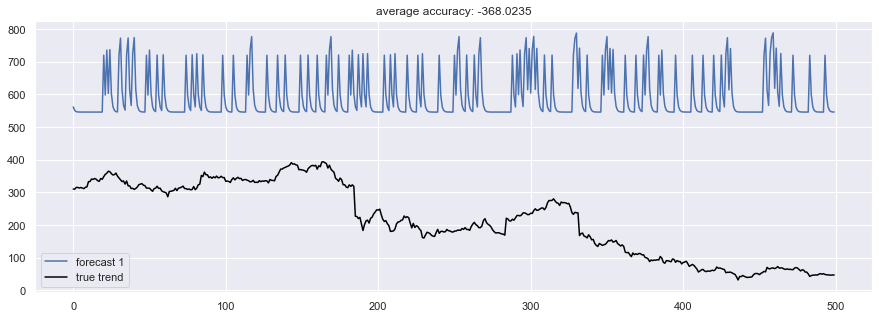

In [49]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

In [31]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [32]:
df.head()

Yes Bank,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,Id,Date,returns
Date,,,,,,,,,,,,,,,
2013-07-26,381.0,382.00,342.40,367.20,361.479776,2628180.0,61178.0,9.500339e+08,337000.0,12.82,39.60,-13.80,2000,2013-07-26,-0.017262
2013-07-29,368.8,370.80,357.00,363.30,365.166637,808939.0,20507.0,2.953975e+08,80192.0,9.91,13.80,-5.50,2001,2013-07-29,-0.010621
2013-07-30,363.8,375.00,346.75,348.90,360.999626,1132155.0,32198.0,4.087075e+08,187475.0,16.56,28.25,-14.90,2002,2013-07-30,-0.039637
2013-07-31,349.0,349.00,288.55,323.80,313.937418,3452309.0,74519.0,1.083809e+09,606840.0,17.58,60.45,-25.20,2003,2013-07-31,-0.071940
2013-08-01,330.0,339.05,304.25,327.65,323.129726,2270048.0,54892.0,7.335200e+08,374878.0,16.51,34.80,-2.35,2004,2013-08-01,0.011890


In [33]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [34]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [35]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [36]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()
        


In [38]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(100, 10)

iter 10. reward: 125.934000
iter 20. reward: 230.191500
iter 30. reward: 235.617000
iter 40. reward: 320.298000
iter 50. reward: 372.942500
iter 60. reward: 419.708000
iter 70. reward: 443.427000
iter 80. reward: 492.997000
iter 90. reward: 465.681000
iter 100. reward: 482.781000
time taken to train: 281.51589274406433 seconds


day 0: buy 5 units at price 1836.000000, total balance 8164.000000
day 1, sell 5 units at price 1816.500000, investment -1.062092 %, total balance 9980.500000,
day 6: buy 5 units at price 1496.750000, total balance 8483.750000
day 10: buy 5 units at price 1506.000000, total balance 6977.750000
day 13: buy 5 units at price 1290.000000, total balance 5687.750000
day 15, sell 5 units at price 1213.750000, investment -18.907633 %, total balance 6901.500000,
day 16: buy 5 units at price 1277.750000, total balance 5623.750000
day 17: buy 5 units at price 1213.500000, total balance 4410.250000
day 19: buy 1 units at price 261.050000, total balance 4149.200000
day 21: buy 5 units at price 1129.500000, total balance 3019.700000
day 23: buy 5 units at price 1216.250000, total balance 1803.450000
day 25, sell 5 units at price 1147.000000, investment -23.837981 %, total balance 2950.450000,
day 27, sell 5 units at price 1436.750000, investment 11.375969 %, total balance 4387.200000,
day 29, sell 5

day 795: buy 1 units at price 1317.050000, total balance 19605.500000
day 797, sell 5 units at price 6539.250000, investment 379.839301 %, total balance 26144.750000,
day 798, sell 5 units at price 6444.000000, investment -10.555903 %, total balance 32588.750000,
day 799: buy 5 units at price 6271.250000, total balance 26317.500000
day 800: buy 1 units at price 1271.900000, total balance 25045.600000
day 801, sell 5 units at price 6338.000000, investment 1.132918 %, total balance 31383.600000,
day 803, sell 5 units at price 6054.000000, investment 402.594330 %, total balance 37437.600000,
day 805: buy 5 units at price 5982.000000, total balance 31455.600000
day 806: buy 5 units at price 6029.750000, total balance 25425.850000
day 807, sell 5 units at price 6119.750000, investment 402.566314 %, total balance 31545.600000,
day 809: buy 1 units at price 1290.700000, total balance 30254.900000
day 811, sell 5 units at price 5794.250000, investment -7.013039 %, total balance 36049.150000,
d

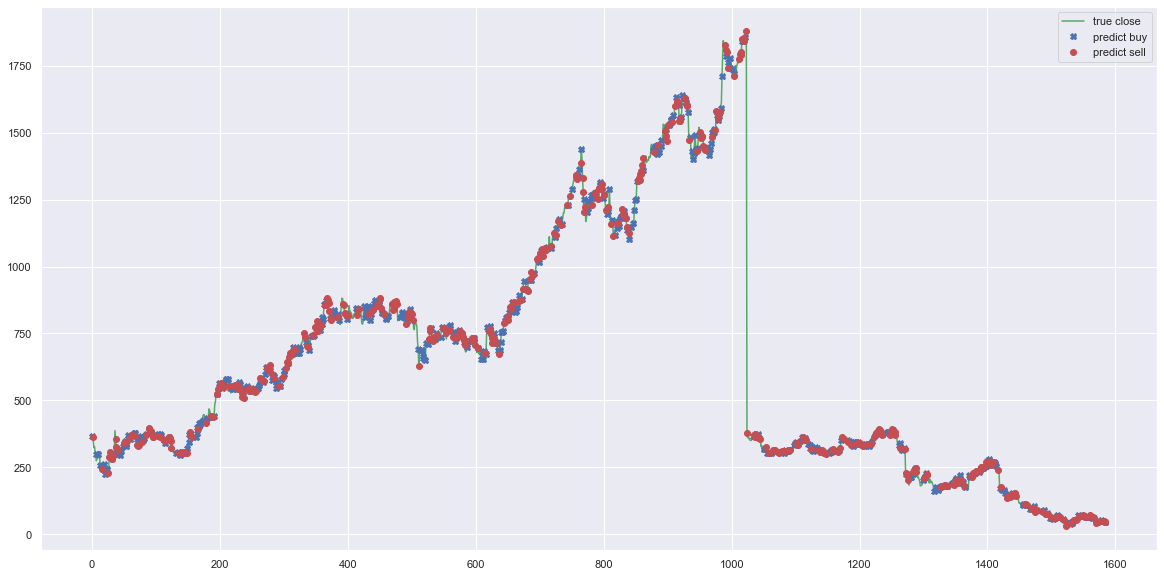

In [39]:
agent.buy()